In [471]:
from IPython.display import display, HTML
display(HTML("""
<style>
.jp-Notebook {
    max-width: 100% !important;
}
.jp-Cell {
    max-width: 100% !important;
}
</style>
"""))


In [457]:
import nglutils as ngu
import pickle 
import numpy as np
import pandas as pd 
import nglview as nv
import polars as pl 
import mdtraj as md
from nglutils import xyz2nglview, mdtop_for_polymer   # your helper module
from polychrom.polymerutils import fetch_block

In [626]:
import numpy as np
from scipy.spatial.transform import Rotation

def rotate_points_to_orientation(points: np.ndarray, i1: list[int], i2: list[int], i3: list[int], axes: str = "XY") -> np.ndarray:
    """
    Rotate points so reference triangle has i1 "up", i2 "down-left", i3 "down-right".
    
    Args:
        points: nx3 array of 3D points
        i1, i2, i3: indices of reference points
        axes: "XY" means X=horizontal, Y=vertical. Can be "YX", "XZ", etc.
    """
    # Parse axes - first char is horizontal, second is vertical
    axis_map = {"X": 0, "Y": 1, "Z": 2}
    h_axis = axis_map[axes[0].upper()]  # horizontal
    v_axis = axis_map[axes[1].upper()]  # vertical
    d_axis = ({0, 1, 2} - {h_axis, v_axis}).pop()  # depth
    
    # Center on reference triangle
    r1 = points[i1].mean(axis=0)
    r2 = points[i2].mean(axis=0)
    r3 = points[i3].mean(axis=0)
    ref_points = np.array([r1, r2, r3])
    center = np.mean(ref_points, axis=0)
    points_centered = points - center
    ref_centered = ref_points - center
    
    # Current configuration vectors
    current_up = ref_centered[0]  # i1 position
    current_mid = (ref_centered[1] + ref_centered[2]) / 2  # midpoint of i2, i3
    current_right = ref_centered[2] - ref_centered[1]  # i2 -> i3 vector
    
    # Target configuration
    target = np.zeros((3, 3))
    
    # Place i1 "up" on vertical axis
    up_dist = np.linalg.norm(current_up - current_mid)
    target[0, v_axis] = up_dist
    
    # Place i2, i3 "down" and symmetric left/right
    down_y = -up_dist * 0.5  # approximate "down" 
    side_x = np.linalg.norm(current_right) * 0.5
    
    target[1, v_axis] = down_y  # i2 down
    target[1, h_axis] = -side_x  # i2 left
    
    target[2, v_axis] = down_y  # i3 down  
    target[2, h_axis] = side_x   # i3 right
    
    # Compute rotation using Procrustes-like approach
    # Find rotation R such that R @ current ≈ target
    H = ref_centered.T @ target
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    
    # Ensure proper rotation (det = 1)
    if np.linalg.det(R) < 0:
        Vt[-1] *= -1
        R = Vt.T @ U.T
    
    return points_centered @ R.T

In [648]:
outputs  = [fetch_block("trajectory",i, full_output=True ) for i in range(100,2550)]

In [651]:


from scipy.ndimage import gaussian_filter1d

structures = pickle.loads(outputs[-1]["structures"].tobytes())

rbs = ["ribbon1", "ribbon2"]
i1 = [structures[r].start_particle_index + 28 for r in rbs]
i2 = [structures[r].start_particle_index + 0 for r in rbs]
i3 = [structures[r].get_end_idx()  for r in rbs]


pos0 = np.array([i["pos"] for i in outputs])

pos = gaussian_filter1d(pos0,4, axis=0)

results = []
for i in pos:
    rot = rotate_points_to_orientation(i, i1, i2, i3, "XY")
    if np.isfinite(rot).all():
        results.append(rot)

pos = np.array(results)



bonds = outputs[-1]["bonds"]
bond_pos = np.array(bonds[:, :2], dtype=np.int64)
# --------------------------------------------------
# 2. build a topology with *only* those bonds -------
N = pos.shape[1]
top = mdtop_for_polymer(
    N,
    exclude_bonds=np.arange(1, N),   # nuke the default chain bonds
    add_bonds=bond_pos,
    atom_names="CUB",                # any 3-char label
)

# --------------------------------------------------
# 3. shove into nglview -----------------------------
view = xyz2nglview(pos*2, top=top)  # helper from your file
view.clear_representations()         # kill default “lines”


#pickle.dump(pos, open("folded_conf.pkl", 'wb'))


structures.keys()
smc_color = "orange" 
nipbl_color = "green"
base_color = "gray"
colors = pd.Series(["base_color"] * structures.next_idx(), name="color")

for s in ["ribbon1", 'ribbon2', 'polymer1', 'polymer2', 'polymer3']:
    stru = structures[s]
    colors.iloc[stru.start_particle_index:stru.get_next_idx()] = smc_color


stru = structures["nipbl1"]
colors.iloc[stru.start_particle_index:stru.get_next_idx()] = nipbl_color

stru = structures["hinge_stick1"]
colors.iloc[stru.start_particle_index:stru.get_next_idx()] = nipbl_color

for i,j in pl.from_pandas(colors.to_frame().reset_index()).group_by("color").agg(pl.col("index")).iter_rows():
    view.add_representation("ball+stick", selection=j, color = i, radius=0.2)
view


/var/folders/k4/87l5bsb52hd3_hjmy15klwch0000gn/T/ipykernel_74350/2458223930.py:61: RuntimeWarning: divide by zero encountered in matmul
  return points_centered @ R.T
/var/folders/k4/87l5bsb52hd3_hjmy15klwch0000gn/T/ipykernel_74350/2458223930.py:61: RuntimeWarning: overflow encountered in matmul
  return points_centered @ R.T
/var/folders/k4/87l5bsb52hd3_hjmy15klwch0000gn/T/ipykernel_74350/2458223930.py:61: RuntimeWarning: invalid value encountered in matmul
  return points_centered @ R.T


NGLWidget(max_frame=2449)

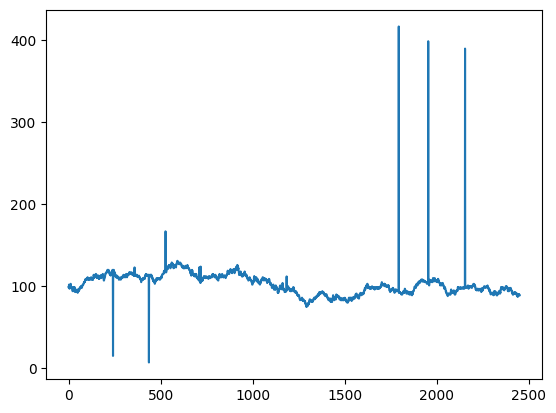

In [649]:
ring_inds = np.arange(structures["ring"].start_particle_index, structures["ring"].start_particle_index+420, dtype=int)
polymer_inds = []
for struc in [structures["polymer2"], structures["polymer3"]]:
    polymer_inds.append(np.arange(struc.start_particle_index, struc.get_next_idx()))
polymer_inds = np.concat(polymer_inds)

args = []
for otp in outputs:
    pos = otp["pos"]
    dists = np.linalg.norm(pos[ring_inds][:,None,:] - pos[polymer_inds][None,:,:], axis=-1)
    dists = np.mean(dists, axis=1)
    arg = np.argmin(dists)
    args.append(arg)
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(args)

In [633]:
pos0

array([[[  6.90483,  -1.0684 ,  -3.98466],
        [  6.21227,  -1.80888,  -4.04429],
        [  7.61818,  -1.7107 ,  -3.7233 ],
        ...,
        [ 20.77545,  -3.95587, -47.70526],
        [ 20.13649,  -5.7997 , -49.63818],
        [ 19.61792,  -5.85634, -47.46378]],

       [[  6.91367,  -0.93349,  -3.29075],
        [  6.24484,  -1.74811,  -3.42116],
        [  7.67009,  -1.58545,  -3.06871],
        ...,
        [ 20.99506,  -4.75723, -49.48881],
        [ 21.18298,  -6.21724, -47.63758],
        [ 21.32859,  -6.24901, -45.87201]],

       [[  6.3499 ,  -0.53458,  -3.06049],
        [  5.89705,  -1.09123,  -3.79253],
        [  7.15482,  -1.21282,  -3.02912],
        ...,
        [ 18.82994,  -5.4942 , -49.04472],
        [ 19.74204,  -4.4746 , -46.39232],
        [ 22.02092,  -4.96774, -45.3548 ]],

       ...,

       [[ -5.87168,  -6.9461 , -34.27558],
        [ -6.10708,  -7.76993, -33.67914],
        [ -5.46857,  -6.49632, -33.44536],
        ...,
        [ 10.7353 ,   8.80

In [498]:
#pickle.dump(pos0[79], open("start_try1.pkl", 'wb'))
pickle.dump(pos0[79], open("captured_try1.pkl", 'wb'))

In [291]:
def f(x):
    term1 = ( x* np.sqrt(6/7)) / (1.05 )
    term2 = 1 + (term1**12) * (term1**2 - 1) * (823543/46656)
    return 4 * term2

f(0.92)

np.float64(2.0397133639672496)